In [1]:
import math
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline
pd.options.display.float_format='{:.2f}'.format
pd.options.display.max_rows = 999

df = pd.read_csv('../data/000015', index_col= 'Date', names=['Date', 'Open', 'Close', 'High', 'Low', 'Volume', 'Money', 'PE', 'PB'], parse_dates=True, header=None)

df['Return'] = df['Close'].pct_change() * 100

# Converting daily returns to monthly returns

In [ ]:
df_monthly = pd.DataFrame(df['Close'].asfreq('M', method='ffill'))

df_monthly['Return'] = df_monthly.pct_change() * 100
df_monthly

# Converting daily returns to quarterly returns

In [ ]:
df_quarterly = pd.DataFrame(df['Close'].asfreq('Q', method='ffill'))

df_quarterly['Return'] = df_quarterly.pct_change() * 100
df_quarterly

# Converting daily returns to annual returns

In [ ]:
df_annual = pd.DataFrame(df['Close'].asfreq('A', method='ffill'))

df_annual['Return'] = df_annual.pct_change() * 100
df_annual

# Tests of equal means and equal variances

In [ ]:
df1 = pd.read_csv('../data/000015', index_col= 'Date', names=['Date', 'Open', 'Close', 'High', 'Low', 'Volume', 'Money', 'PE', 'PB'], parse_dates=True, header=None)
df2 = pd.read_csv('../data/000300', index_col= 'Date', names=['Date', 'Open', 'Close', 'High', 'Low', 'Volume', 'Money', 'PE', 'PB'], parse_dates=True, header=None)

df1['Return'] = df1['Close'].pct_change() * 100
df2['Return'] = df2['Close'].pct_change() * 100

print(stats.bartlett(df1['Return'][1:],df2['Return'][1:]))

# Test the February effect

In [ ]:
ret_feb = df_monthly[df_monthly.index.month==2].dropna()
ret_others = df_monthly[df_monthly.index.month!=2].dropna()

print(stats.bartlett(ret_feb.values, ret_others.values))

# Decile and quartile analysis

C:\software\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: FutureWarning: 
.resample() is now a deferred operation
You called resample(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead
C:\software\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill()


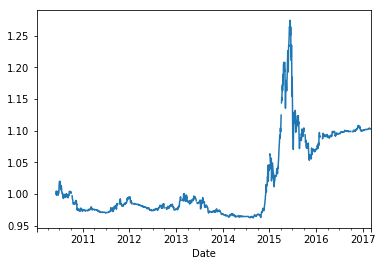

In [4]:
def to_index(rets):
    index = (1 + rets).cumprod()
    first_loc = max(index.index.get_loc(index.notnull().argmax()) - 1, 0)
    index.values[first_loc] = 1
    return index

def trend_signal(rets, lookback, lag):
    signal = rets.rolling(window=lookback, min_periods=lookback-5).sum()
    return signal.shift(lag)

returns = df['Return'] / 100

signal = trend_signal(returns, 100, 3)
trade_friday = signal.resample('W-FRI').resample('B', fill_method='ffill')
trade_rets = trade_friday.shift(1) * returns
to_index(trade_rets).plot()

In [24]:
#vol = pd.rolling_std(returns, 250, min_periods=200) * np.sqrt(250)
vol = returns.rolling(window=250, min_periods=200).std() * np.sqrt(250)
aligned_rets, aligned_vol = trade_rets.align(vol, join='right')

def sharpe(rets, ann=250):
    return rets.mean() / rets.std() * np.sqrt(ann)

aligned_rets.groupby(pd.qcut(aligned_vol, 4)).agg(sharpe)

Return
[0.125, 0.187]    1.76
(0.187, 0.216]   -0.42
(0.216, 0.244]    1.50
(0.244, 0.428]   -0.58
Name: Return, dtype: float64

# Signal frontier analysis

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import mytrade as t
import talib
import collections

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_rows', 9999) 
#pd.set_option('precision', 3)
pd.set_option('display.float_format', '{:.2f}'.format)

indexes = [
    '000001.XSHG',   #上证指数
    '399001.XSHE',   #深成指
    '399005.XSHE',   #中小板指
    '399102.XSHE',   #创业板综合指数
    '000905.XSHG',   #中证500 
    '000015.XSHG',   #红利指数
    '399932.XSHE',   #中证消费
    '399933.XSHE',   #中证医药
    '399396.XSHE',   #国证食品
    '399610.XSHE',   #TMT50
]

prices = get_price(indexes, count = 240, end_date = t.today_str, fields=['close'])['close']
def calc_mom(price, lookback, lag):
    mom_ret = prices.shift(lag).pct_change(lookback)
    ranks = mom_ret.rank(axis=1, ascending=False)
    demeaned = ranks - ranks.mean(axis=1)
    return demeaned / demeaned.std(axis=1)

compound = lambda x : (1 + x).prod() - 1
daily_sr = lambda x: x.mean() / x.std()

def strat_sr(prices, lb, hold):
    # Compute portfolio weights
    freq = '%dB' % hold
    port = calc_mom(prices, lb, lag=1)
    daily_rets = prices.pct_change()
    # Compute portfolio returns
    port = port.shift(1).resample(freq, how='first')
    returns = daily_rets.resample(freq, how=compound)
    port_rets = (port * returns).sum(axis=1)
    return daily_sr(port_rets) * np.sqrt(252 / hold)

lookbacks = range(20, 90, 5)
holdings = range(20, 90, 5)
dd = collections.defaultdict(dict)
for lb in lookbacks:
    for hold in holdings:
        dd[lb][hold] = strat_sr(prices, lb, hold)
ddf = pd.DataFrame(dd)
ddf.index.name = 'Holding Period'
ddf.columns.name = 'Lookback Period'

def heatmap(df, cmap=plt.cm.gray_r):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    axim = ax.imshow(df.values, cmap=cmap, interpolation='nearest')
    ax.set_xlabel(df.columns.name)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(list(df.columns))
    ax.set_ylabel(df.index.name)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(list(df.index))
    plt.colorbar(axim)
    
heatmap(ddf)

# Rolling correlation and linear regression

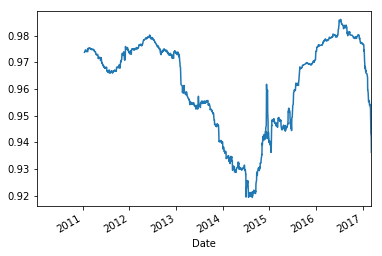

In [5]:
df1 = pd.read_csv('../data/000015', index_col= 'Date', names=['Date', 'Open', 'Close', 'High', 'Low', 'Volume', 'Money', 'PE', 'PB'], parse_dates=True, header=None)
df2 = pd.read_csv('../data/000300', index_col= 'Date', names=['Date', 'Open', 'Close', 'High', 'Low', 'Volume', 'Money', 'PE', 'PB'], parse_dates=True, header=None)

rets1 = df1['Close'].pct_change()
rets2 = df2['Close'].pct_change()

rets1.rolling(window=250).corr(rets2).plot()

One issue with correlation between two assets is that it does not capture differences in volatility. Least-squares regression provides another means for modeling the dynamic relationship between a variable and one or more predictor variables.

C:\software\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://www.statsmodels.org/stable/regression.html
  if __name__ == '__main__':


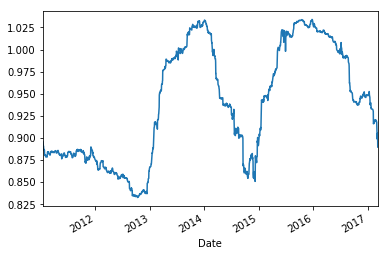

In [7]:
model = pd.ols(y=rets1, x={'300': rets2}, window=250)
model.beta['300'].plot()